## Import Libraries

In [1]:
#!/usr/bin/env python
# coding: utf-8
from PIL import Image
import requests
from io import BytesIO

import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import plotly.express as px

from datetime import datetime

#Set Display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

pd.options.display.float_format = '{:.2f}'.format


In [5]:
# Variables
season = "2020-21"

## Import Data from Files

In [7]:
all_players = pd.read_csv(r"./data/" + season + "/Merged_data/all_players_merged.csv" , parse_dates= ["news_added"]) 
player_gameweek_history = pd.read_csv(r"./data/" + season + "/Cleaned_data/player_gameweek_history.csv") 
all_teams = pd.read_csv(r"./data/" + season + "/Cleaned_data/all_teams.csv")
all_events = pd.read_csv(r"./data/" + season + "/Cleaned_data/all_events.csv" , parse_dates= ["deadline_time"])


In [9]:
def get_player_photo(player_id):
    player = all_players[all_players.player_id == player_id]
    photo_id = player.iloc[0].photo.split('.')[0]

    url = 'https://resources.premierleague.com/premierleague/photos/players/110x140/p' + photo_id + '.png'

    response = requests.get(url)
    return Image.open(BytesIO(response.content))

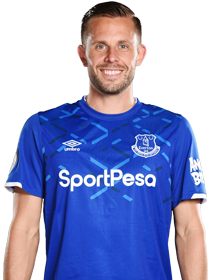

In [10]:
get_player_photo(150)

## Graph - Total points per gameweek

In [11]:
all_players.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round',
       'player_code', 'cost_change_event', 'cost_change_event_fall',
       'cost_change_start', 'cost_change_start_fall', 'dreamteam_count',
       'player_type_id', 'ep_next', 'ep_this', 'event_points', 'form',
       'player_id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo',
       'PPG', 'selected_by_percent', 'status', 'team_id', 'team_code',
       'total_points', 'transfers_in_event', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank', 'threat_rank_type',
       'ict_index_rank', 'ict_index_rank_type', 'PP90', 'VAPM', 'PP

In [12]:
def player_summary(player_id):
    data = player_gameweek_history[player_gameweek_history.player_id == player_id]

    player = all_players[all_players.player_id == player_id]
    goals_scored = player.iloc[0].goals_scored
    player_name = player.iloc[0]['web_name']

    fig = px.line(
        data, 
        x = 'round', 
        y = 'total_points', 
        title = player_name,
        hover_data=[])

    fig.show()


In [13]:
player_summary(150)

# SMA ANALYSIS OF PLAYERS

In [15]:
player_gameweek_history.columns

Index(['player_id', 'fixture_id', 'opponent_team_id', 'total_points',
       'was_home', 'kickoff_time', 'team_h_score', 'team_a_score', 'round',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out'],
      dtype='object')

In [14]:
    player_analysis = player_gameweek_history[player_gameweek_history.player_id == 150]
    player_analysis = player_analysis[["player_id", "gameweek_id"  , "total_points" , "opponent_strength" , "web_name"]]
    player_analysis['gameweek_id']= player_analysis['gameweek_id'].astype(str)
    player_analysis.set_index("gameweek_id")

    #player_analysis.dtypes
    player_analysis.head()


KeyError: "['opponent_strength', 'web_name', 'gameweek_id'] not in index"

In [13]:
def get_SMA(opponent_strength, total_points, gw_period):
    
    # List to store moving average results
    SMA = list(range(0, len(total_points) - gw_period))
    SMA2 = list(range(0, len(total_points) - gw_period))

    # Compute moving average
    for ii in range(len(SMA)):
        # Previous gw index
        index = range(ii, ii + gw_period)
        # Get data for previous gw
        prev_gw = total_points.iloc[index]
        prev_gw2 = opponent_strength.iloc[index]

        # Sum previous gw
        summation = np.sum(prev_gw)
        summation2 = np.sum(prev_gw2)

        # Get average
        avg = summation/gw_period
        avg2 = summation2/gw_period
        # Save results to list
        SMA[ii] = avg
        SMA2[ii] = avg2
         
    # Define column label
    label = f"Total points SMA"
    label2 = f"Opponent strength SMA"

    
    # Get corresponding gw for moving_avg
    gameweeks = total_points.index[gw_period:]
    gameweeks2 = opponent_strength.index[gw_period:]
    
    # Convert list into Pandas Series
    SMA = pd.Series(SMA, name = label, index = gameweeks)
    SMA2 = pd.Series(SMA2, name = label2, index = gameweeks2)
    
    return SMA, SMA2

### MAKE GRAPH

In [11]:
###############################################################
# 6b. Candlestick charts, Moving Averages, and Volume: Figure #
###############################################################

def CreateTrendGraph(player_name , tp_SMA , os_SMA):
    # Set fontsize
    sns.set(font_scale = 1.5)

    # Set graph style
    sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85",  'axes.grid': True, "grid.color": "0.85",
                   "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
                   'ytick.color': '0.4'})

    # Create figure
    f, ax = plt.subplots(figsize=(20, 20), nrows = 2, ncols = 1)
    
    ### PLOT STOCK TREND PLOT ###

    #total_points.plot(kind='bar', color = ["grey"], style = ["-"], linewidth = 2.5, ax = ax[0])

    # Plot 50-day SMA
    tp_SMA.plot(color = ["magenta"], style = ["-"], linewidth = 2.5, ax = ax[0] , use_index = True)

    # Plot 200-day SMA
    os_SMA.plot(color = ["b"], style = ["-"], linewidth = 2.5, ax = ax[0], use_index = True)

    # Set x and y axis limits
    ax[0].margins(0.1)
    
    # Title
    ax[0].set_title(f"Player Analysis - {player_name}")

    # Set axis labels
    ax[0].set_ylabel("Value", fontsize = 20)
    ax[0].set_xlabel("Gameweek")

    # Send gridlines to back
    ax[0].set_axisbelow(True)

    # Show legend
    ax[0].legend()

    # Plot on subplot 2

    #total_points.plot(kind='bar', color = ["grey"], style = ["-"], linewidth = 2.5, ax = ax[0])

    # Tight layout
    plt.tight_layout()

    # Save Figure
    #plt.savefig('./data/'+ stock + " Trend Analysis.png", dpi = quality)

In [12]:
def CreatePlayerAnalysis(player_id , gw_period):
    player_analysis = player_gameweek_history[player_gameweek_history.player_id == player_id]
    player_analysis = player_analysis[["player_id", "gameweek_id"  , "total_points" , "opponent_strength" , "web_name"]].set_index("gameweek_id")

    player_name = player_analysis.iloc[0]['web_name']
    total_points = player_analysis.iloc[:,1]
    opponent_strength = player_analysis.iloc[:,2]
    tp_SMA, os_SMA = get_SMA(opponent_strength, total_points, gw_period)

    CreateTrendGraph(player_name , tp_SMA , os_SMA)

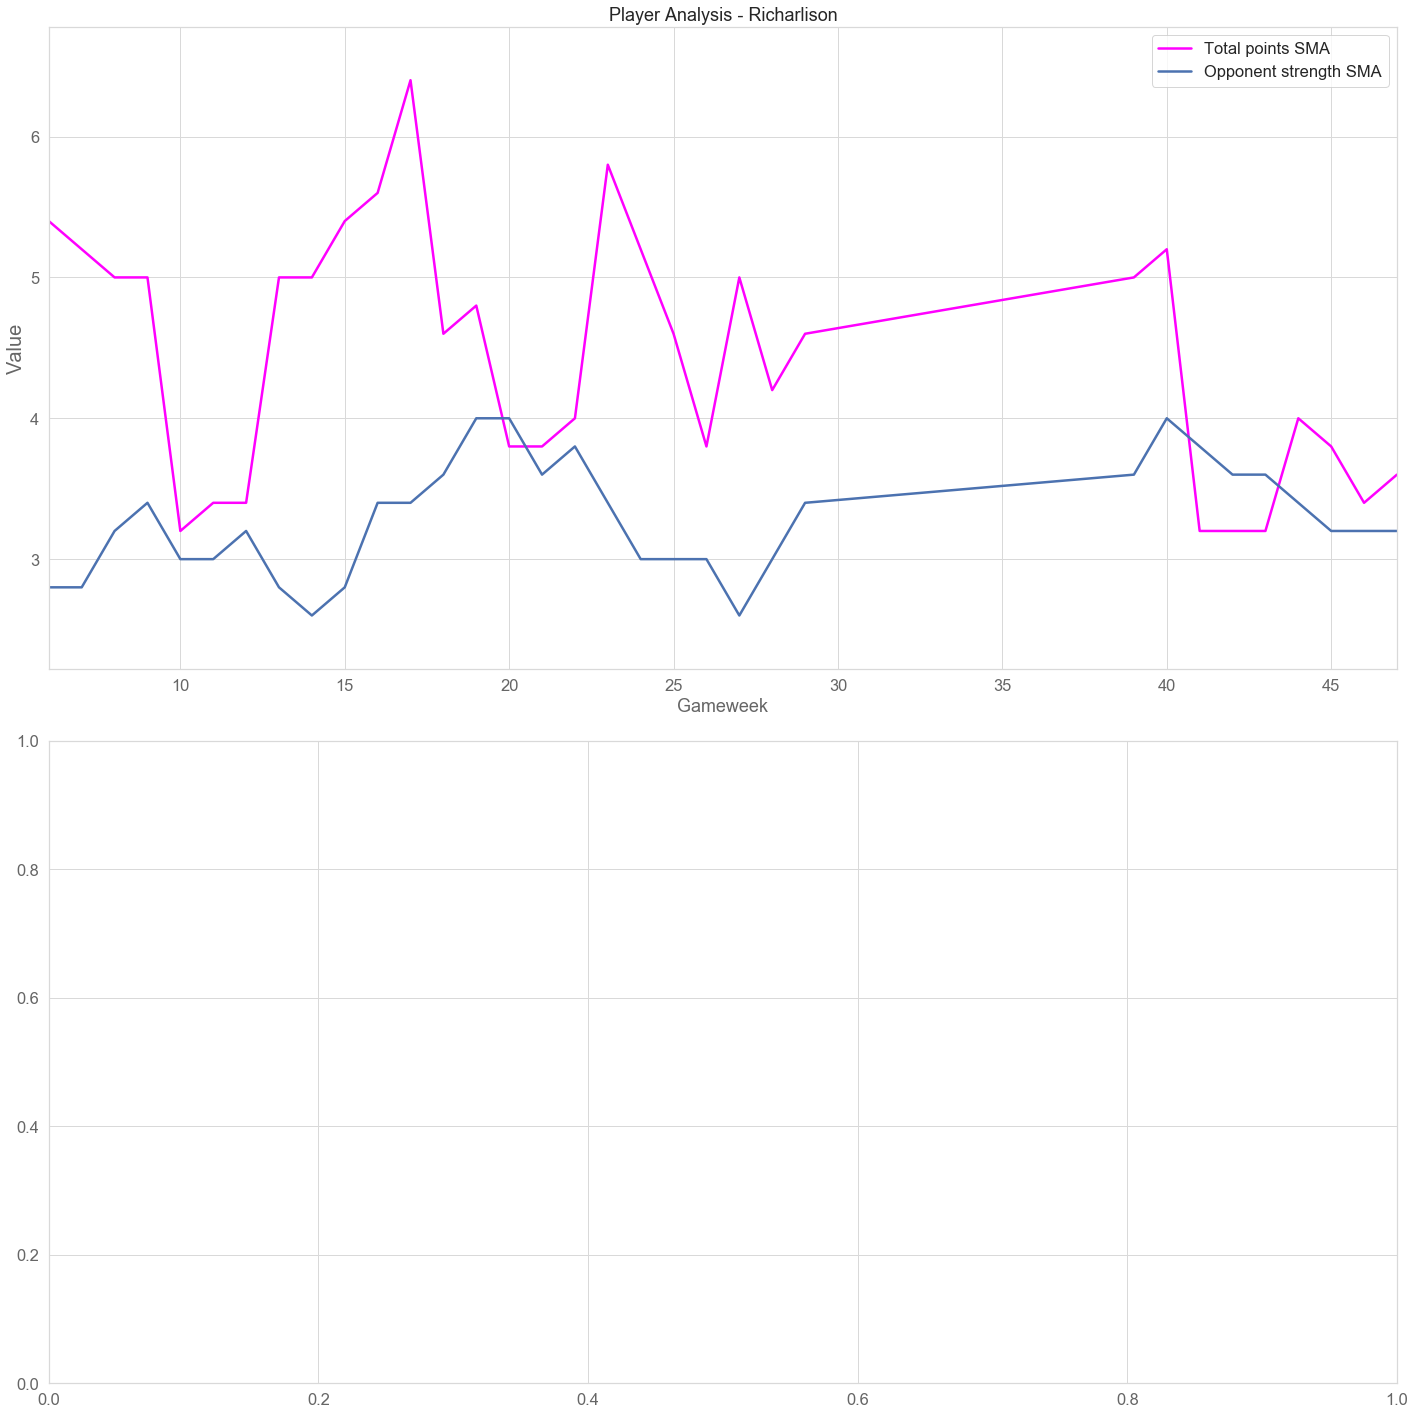

In [13]:
CreatePlayerAnalysis(150 , 5)

In [14]:
player_analysis = player_gameweek_history[player_gameweek_history.player_id == 150]
player_analysis = player_analysis[["player_id", "gameweek_id"  , "total_points" , "opponent_strength" , "web_name"]].set_index("gameweek_id")

player_name = player_analysis.iloc[0]['web_name']
total_points = player_analysis.iloc[:,1]
opponent_strength = player_analysis.iloc[:,2]

tp_SMA , os_SMA = get_SMA(opponent_strength, total_points, 5)
mergedDf = pd.concat([tp_SMA, total_points], axis=1).dropna()

mergedDf['diff'] = mergedDf['total_points'] - mergedDf['Total points SMA']
mergedDf.head(6)


,Total points SMA,total_points,diff
gameweek_id,,,
6,5.40,2,-3.40
7,5.20,2,-3.20
8,5.00,2,-3.00
9,5.00,6,1.00
10,3.20,5,1.80
11,3.40,2,-1.40


## POINTS AT HOME VS AWAY ANALYSIS

In [15]:
def points_when_home():
    data = player_analysis[player_analysis.was_home == True]
    points_at_home = data.total_points.agg("sum")
    


In [16]:
name_list = []
form_list = []
diff_list = []
max_points_list = []
min_points_list = []

now = datetime.now()
current_gw = all_events[all_events['deadline_time'] < now]['gameweek_id'].max()
number_of_players = len(all_players)

#current_gw = all_events[all_events['deadline_time'] < now]['gameweek_id'].max()


def player_past_stats(player_id, number_of_games):
    df = player_gameweek_history[player_gameweek_history.player_id == player_id]

    player = all_players[all_players.player_id == player_id]
    player_name = player.iloc[0]['web_name']

    gw_current = current_gw
    gw_first = gw_current - (number_of_games - 1)
    df = df[(df['gameweek_id'] >= gw_first) & (df['gameweek_id'] <= gw_current)]

    form = df.total_points.agg("average")
    difficulty = df.opponent_strength.agg("average")
    max_points = df.total_points.agg("max")
    min_points = df.total_points.agg("min")

    name_list.append(player_name)
    form_list.append(form)
    diff_list.append(difficulty)
    max_points_list.append(max_points)
    min_points_list.append(min_points)

    #print (str(player_name) + " has an average of " + "{:.2f}".format(form) + " points per game in the last " + str(number_of_games) + " games.")

def player_past_stats_df(number_of_games):
    for i in range(number_of_players):
        try:
            player_past_stats(i+1,number_of_games)
        except IndexError:
            continue
    
    col_name1 = "Average total points last " + str(number_of_games) + " GW"
    col_name2 = "Average fixture difficulty last " + str(number_of_games) + " GW"
    

    form_df = pd.DataFrame({'Name' : name_list , col_name1 : form_list , col_name2 : diff_list , "Min Points" : min_points_list , "Max points" : max_points_list })
    form_df.sort_values(col_name1 , ascending=False, inplace = True)

    return form_df

player_past_stats_df(10).head(10)

,Name,Average total points last 20 GW,Average fixture difficulty last 20 GW,Min Points,Max points
614,Fernandes,8.64,2.91,1.00,15.00
238,Martial,8.00,2.91,2.00,21.00
213,Sterling,8.00,3.18,0.00,21.00
388,Antonio,7.09,3.27,0.00,26.00
214,De Bruyne,6.64,3.18,0.00,19.00
112,Willian,6.27,3.09,0.00,14.00
400,Doherty,6.18,2.91,0.00,12.00
312,Ings,5.55,3.00,1.00,13.00
191,Mané,5.55,3.09,0.00,13.00
190,Salah,5.27,3.09,0.00,18.00
